In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import GridSearchCV
import xgboost as xgb



---


#ПОСМОТРИМ НА ДАННЫЕ

In [ ]:
data = pd.read_csv("train.csv", index_col=False)
data.head(5)

,id,plate,date,price
0,1,X059CP797,2024-12-26 00:00:00,65000
1,2,Y800MH790,2024-07-12 21:31:37,100000
2,3,A212TX77,2024-04-18 00:00:00,290000
3,4,P001AY199,2025-01-03 00:27:15,680000
4,5,P001AY199,2025-01-10 09:32:41,750000


In [ ]:
data.shape

(51635, 4)

In [ ]:
print(len(data["plate"]) - len(set(data["plate"])))

8030


#В ДАННЫХ ИМЕЮТСЯ ДУБЛИКАТЫ 8030шт. А ТОЧНЕЕ , ЭТО ПЕРЕЗАКУПКИ НОМЕРОВ. Т.Е. КОГДА ОДИН НОМЕР БЫЛ ПРОДАН , А В ДАТАФРЕЙМЕ ДАННЫЕ О ВСЕХ ПОКУПКАХ

<ipython-input-202-db8040c463b7>:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


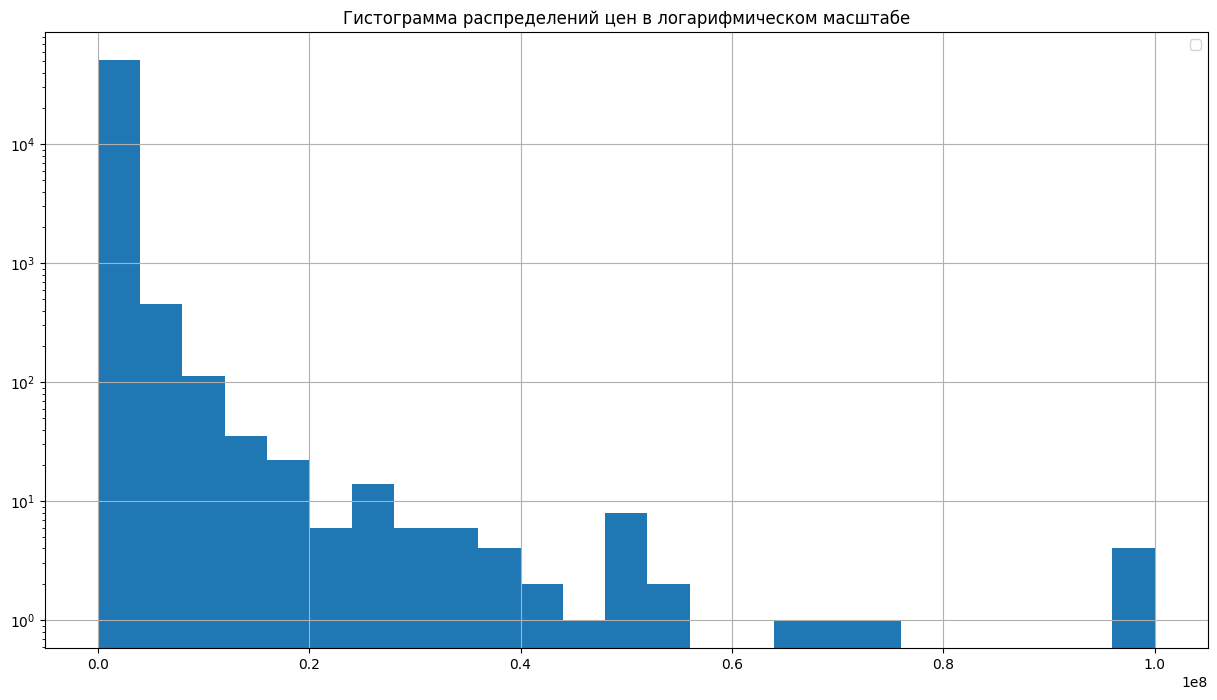

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(data["price"], bins=25, log=True)
plt.title("Гистограмма распределений цен в логарифмическом масштабе")
plt.legend()
plt.grid(True)


---



#ИМПОРТИРУЕМ БИБЛИОТЕКУ DATETIME, ЧТОБЫ РАБОТАТЬ СО ВРЕМЕНЕМ. ИДЕЯ: ОТБРОСИТЬ ВСЕ СТАРЫЕ ПОКУПКИ, ЭТО СВЯЗАНО С ИНФЛЯЦИЕЙ ЦЕН И ТЕМ ФАКТОМ, ЧТО НАС ИНТЕРЕСУЕТ ЦЕНА В ДАННЫЙ МОМЕНТ ВРЕМЕНИ

In [ ]:
current_data = datetime.now()

def data_transform(date_in_data):
    difference_in_time = str(current_data - datetime.strptime(date_in_data, "%Y-%m-%d %H:%M:%S")).split()[0]
    return int(difference_in_time)
data["date"] = data["date"].apply(data_transform)

In [ ]:
data = data.loc[data.groupby("plate")["date"].idxmin()]

In [ ]:
print(len(data["plate"]) - len(set(data["plate"])))

0


In [ ]:
data.isnull().sum()

,0
id,0
plate,0
date,0
price,0


#ПРОПУЩЕННЫХ ЗНАЧЕНИЙ НЕТ

In [ ]:
data.describe()

,id,date,price
count,43605.000000,43605.000000,4.360500e+04
mean,25813.128242,347.051577,4.385499e+05
std,14909.072134,325.871035,1.834355e+06
min,1.000000,31.000000,2.000000e+04
25%,12949.000000,72.000000,7.000000e+04
50%,25789.000000,228.000000,1.500000e+05
75%,38729.000000,553.000000,3.500000e+05
max,51635.000000,1486.000000,1.000000e+08


<ipython-input-208-db8040c463b7>:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


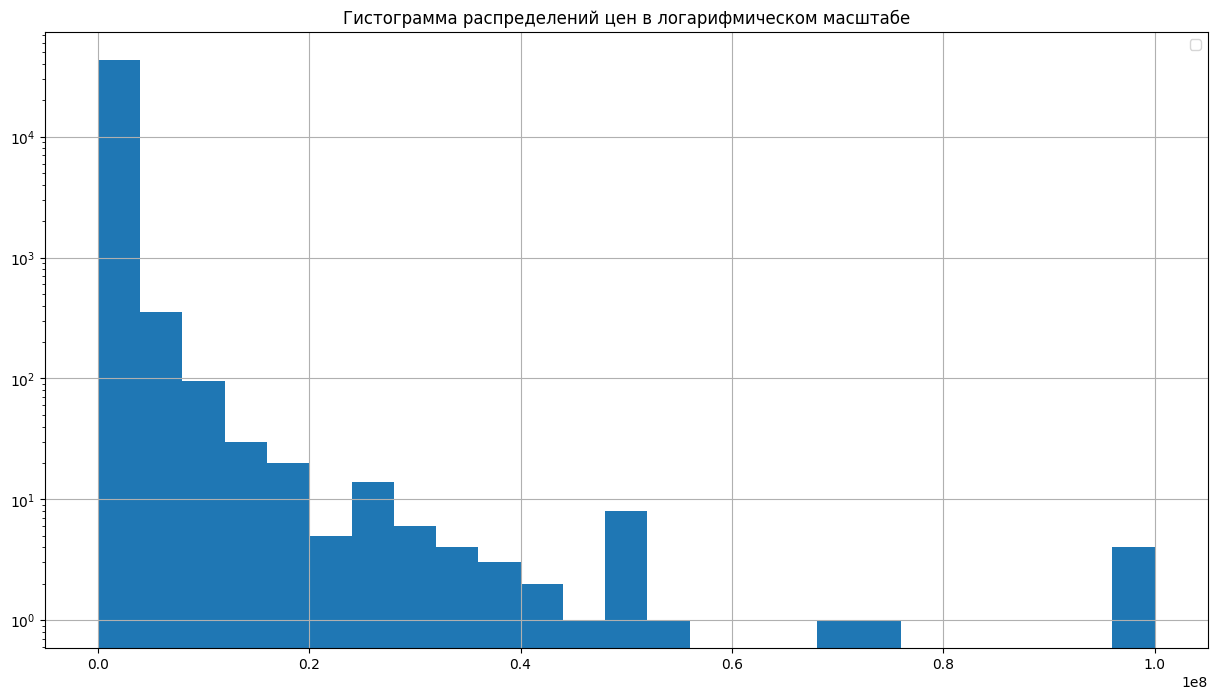

In [ ]:
plt.figure(figsize=(15, 8))
plt.hist(data["price"], bins=25, log=True)
plt.title("Гистограмма распределений цен в логарифмическом масштабе")
plt.legend()
plt.grid(True)


---
#ПОСМОТРИМ НА САМЫЕ НИЗКИЕ И НА САМЫЕ ВЫСОКИЕ ЦЕНЫ


In [ ]:
data[data["price"] == max(data["price"])]

,id,plate,date,price
43878,43879,B777CY77,225,100000000
1794,1795,K252KK777,152,100000000
21108,21109,M026MM08,350,100000000
47081,47082,X777XX05,264,100000000


In [ ]:
data[data["price"] == min(data["price"])]

,id,plate,date,price
27317,27318,A533MM702,504,20000
34078,34079,B904OX797,460,20000
48328,48329,E307KE37,1033,20000
31797,31798,H202EB63,733,20000
16502,16503,K002BY197,798,20000
41754,41755,K053YM777,991,20000
19292,19293,K963OK797,460,20000
38220,38221,O494TP193,343,20000
37652,37653,O780BX799,460,20000
47329,47330,P494MO777,1156,20000


In [ ]:
data.shape

(43605, 4)



---
#ИДЕЯ В ТОМ , ЧТОБЫ КАЖДЫЙ НОМЕР РАЗОБРАТЬ НА КОЛИЧЕСТВО ПОВТОРЯЮЩИХСЯ ЭЛЕМЕНТОВ. ВИДНО ЧТО САМЫМИ ДОРОГИМИ НОМЕРАМИ ЯВЛЯЮТСЯ НОМЕРА ИМЕЮЩИЕ ПОВТОРЯЮЩИЕСЯ БУКВЫ И ЦИФРЫ

#РАЗРАБОТАЕМ АНАЛОГ ONE-HOT-ENCODER'а

In [ ]:
data["Triplet_letters"] = 0
data["Double_letters"] = 0
data["Single_letters"] = 0
data["Sixtet_numbers"] = 0
data["Kvintet_numbers"] = 0
data["Quartet_number"] = 0
data["Triplet_numbers"] = 0
data["Doublet_numbers"] = 0
data["Singlet_numbers"] = 0

for index, plate_in in data[["id", "plate"]].iterrows():
    letter_count = {}
    number_count = {}

    for char in plate_in['plate']:
        if char.isdigit():
            number_count[char] = number_count.get(char, 0) + 1
        else:
            letter_count[char] = letter_count.get(char, 0) + 1

    for let, seq in letter_count.items():
        if seq == 3:
            data.loc[index, "Triplet_letters"] += 1
        elif seq == 2:
            data.loc[index, "Double_letters"] += 1
        elif seq == 1:
            data.loc[index, "Single_letters"] += 1

    for num, seq in number_count.items():
        if seq == 6:
            data.loc[index, "Sixtet_numbers"] += 1
        elif seq == 5:
            data.loc[index, "Kvintet_numbers"] += 1
        elif seq == 4:
            data.loc[index, "Quartet_number"] += 1
        elif seq == 3:
            data.loc[index, "Triplet_numbers"] += 1
        elif seq == 2:
            data.loc[index, "Doublet_numbers"] += 1
        elif seq == 1:
            data.loc[index, "Singlet_numbers"] += 1

    data.shape
    letter_count.clear()
    number_count.clear()

In [ ]:
data.sample(6)

,id,plate,date,price,Triplet_letters,Double_letters,Single_letters,Sixtet_numbers,Kvintet_numbers,Quartet_number,Triplet_numbers,Doublet_numbers,Singlet_numbers
21555,21556,A036AA05,353,1000000,1,0,0,0,0,0,0,1,3
20266,20267,O650OT797,37,55000,0,1,1,0,0,0,0,1,4
9359,9360,O797CX777,628,250000,0,0,3,0,1,0,0,0,1
4935,4936,T696TX797,33,80000,0,1,1,0,0,0,0,3,0
34455,34456,C297CC190,384,220000,1,0,0,0,0,0,0,1,4
25270,25271,K777OY24,931,350000,0,0,3,0,0,0,1,0,2


In [ ]:
data.head(4)

,id,plate,date,price,Triplet_letters,Double_letters,Single_letters,Sixtet_numbers,Kvintet_numbers,Quartet_number,Triplet_numbers,Doublet_numbers,Singlet_numbers
22915,22916,A001AA197,134,1000000,1,0,0,0,0,0,0,2,2
18156,18157,A001AA75,298,10000000,1,0,0,0,0,0,0,1,3
45108,45109,A001AA97,117,15000000,1,0,0,0,0,0,0,1,3
24783,24784,A001AE123,287,3500000,0,1,1,0,0,0,0,2,2


#ПОСМОТРИМ НА МАТРИЦУ КОРЕЛЯЦИЙ , ЧТОБЫ УДОСТОВЕРИТЬСЯ В ГИПОТЕЗЕ О СВЯЗИ ЧАСТОТЕ БУКВ И ЦИФР С ЦЕНОЙ НА НОМЕР

In [ ]:
data = data.drop(["id", "plate", "date"], axis=1)

<Axes: >

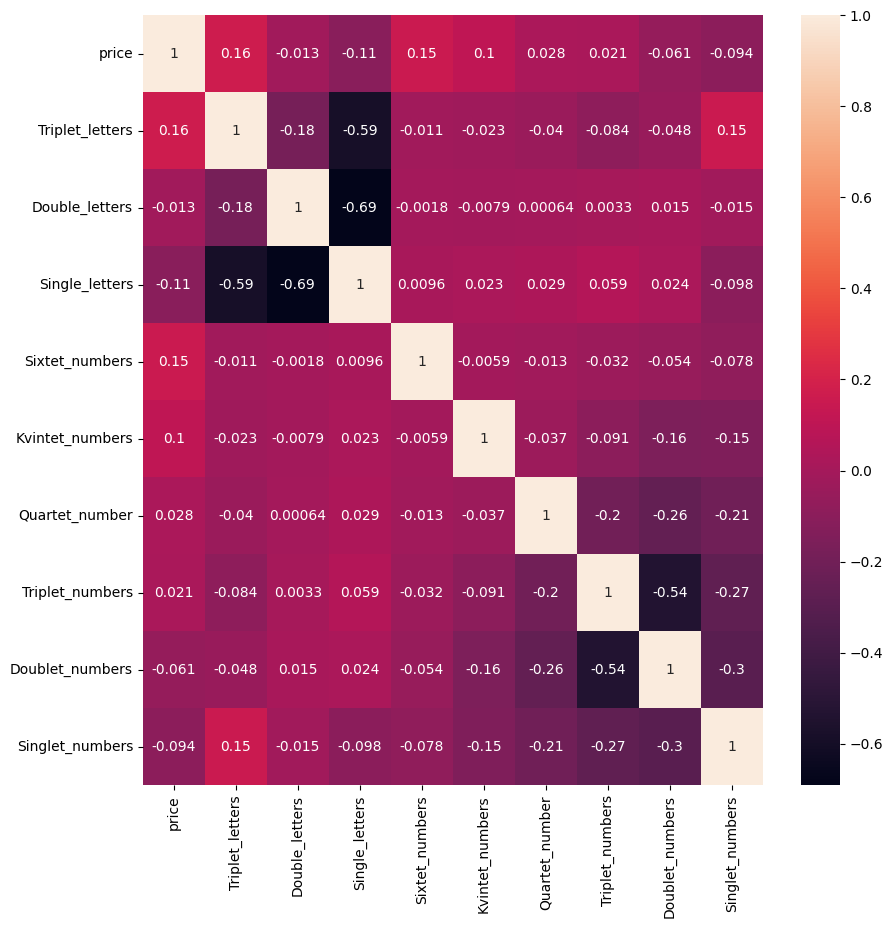

In [ ]:
plt.figure(figsize=(10, 10))
sns.heatmap(data=data.corr(), annot=True)



---
#ПЕРЕЙДЁМ К ПОДБОРУ МОДЕЛИ И ГИПЕРПАРАМЕТРОВ. РАЗОБЬЁМ ДАННЫЕ НА ОБУЧАЮЩУЮ И ТЕСТОВУЮ ВЫБОРКИ , ЧТОБЫ ОЦЕНИТЬ РАБОТОСПОСОБНОСТЬ МОДЕЛИ


In [ ]:
data, y = data.drop(["price"], axis=1), data["price"]

In [ ]:
data.head(4)

,Triplet_letters,Double_letters,Single_letters,Sixtet_numbers,Kvintet_numbers,Quartet_number,Triplet_numbers,Doublet_numbers,Singlet_numbers
22915,1,0,0,0,0,0,0,2,2
18156,1,0,0,0,0,0,0,1,3
45108,1,0,0,0,0,0,0,1,3
24783,0,1,1,0,0,0,0,2,2


In [ ]:
xtrain, xtest, ytrain, ytest = train_test_split(data, y, test_size = 0.2, shuffle=True)
dtree = DecisionTreeRegressor()
dtree.fit(xtrain, ytrain)
#dtree.fit(data, y)
print(mean_absolute_percentage_error(ytest, dtree.predict(xtest)))

2.0522135900703256


In [ ]:
RFS = RandomForestRegressor()
param_grid2 = {
    "n_estimators": [1, 2, 4, 10],
    "max_depth": [20, 25, 30, 35, 40],
    "min_samples_split":[15, 20, 25],
    "min_samples_leaf":[1, 2, 3]
}
grid_search2 = GridSearchCV(estimator=RFS, param_grid=param_grid2, cv=5)
grid_search2.fit(xtrain, ytrain)
print("Best parametrs of RFS ", grid_search2.best_params_)
best_rf = grid_search2.best_estimator_
print(mean_absolute_percentage_error(ytest, best_rf.predict(xtest)))

Best parametrs of RFS  {'max_depth': 30, 'min_samples_leaf': 3, 'min_samples_split': 25, 'n_estimators': 4}
2.081673699482029


In [ ]:
ModelXGB = xgb.XGBRegressor()

param_grid = {
    "n_estimators": [250, 300],
    "max_depth": [7, 10, 15],
    "learning_rate": [0.01, 0.013],
    "subsample": [0.6, 0.8],
    "colsample_bytree": [0.33, 0.66, 1.0]
}
grid_search = GridSearchCV(estimator=ModelXGB, param_grid=param_grid, cv=5)
grid_search.fit(xtrain, ytrain)
best_model = grid_search.best_estimator_
print("The best parametrs: ", grid_search.best_params_)
print("MAPE: ",mean_absolute_percentage_error(ytest, best_model.predict(xtest)))

The best parametrs:  {'colsample_bytree': 0.66, 'learning_rate': 0.013, 'max_depth': 15, 'n_estimators': 300, 'subsample': 0.6}
MAPE:  2.1398978233337402


P.S. На деле я пробовал кууудаа больше гиперпараметров
P.S.S.: не обарщайте внимаение на то что метрика Пня лучше РандомФореста, это дело "буквально" рандомное , на деле метрика РФС для данной задачи выше практически всегда

---



#ДАЛЕЕ ПОДГРУЖАЕМ ТЕСТОВЫЕ ДАННЫЕ , ДЛЯ УЧАСТИЯ В СОРЕВНОВАНИИ НА KAGGLE

In [ ]:
test_data = pd.read_csv("test.csv")
tt = test_data.copy()


test_data["Triplet_letters"] = 0
test_data["Double_letters"] = 0
test_data["Single_letters"] = 0
test_data["Sixtet_numbers"] = 0
test_data["Kvintet_numbers"] = 0
test_data["Quartet_number"] = 0
test_data["Triplet_numbers"] = 0
test_data["Doublet_numbers"] = 0
test_data["Singlet_numbers"] = 0

for index, plate_in in enumerate(test_data["plate"]):
    letter_count = {}
    number_count = {}

    for char in plate_in:
        if char.isdigit():
            number_count[char] = number_count.get(char, 0) + 1
        else:
            letter_count[char] = letter_count.get(char, 0) + 1

    for let, seq in letter_count.items():

        if seq == 3:
            test_data.at[index, "Triplet_letters"] += 1
        elif seq == 2:
            test_data.at[index, "Double_letters"] += 1
        elif seq == 1:
            test_data.at[index, "Single_letters"] += 1

    for num, seq in number_count.items():

        if seq == 6:
            test_data.at[index, "Sixtet_numbers"] += 1
        elif seq == 5:
            test_data.at[index, "Kvintet_numbers"] += 1
        elif seq == 4:
            test_data.at[index, "Quartet_number"] += 1
        elif seq == 3:
            test_data.at[index, "Triplet_numbers"] += 1
        elif seq == 2:
            test_data.at[index, "Doublet_numbers"] += 1
        elif seq == 1:
            test_data.at[index, "Singlet_numbers"] += 1

    test_data.shape
    letter_count.clear()
    number_count.clear()

test_data = test_data.drop(["id", "plate", "date", "price"], axis=1)

In [ ]:
test_data.head(3)

,Triplet_letters,Double_letters,Single_letters,Sixtet_numbers,Kvintet_numbers,Quartet_number,Triplet_numbers,Doublet_numbers,Singlet_numbers
0,0,1,1,0,0,0,1,1,1
1,0,0,3,0,0,0,0,1,4
2,0,0,3,0,0,0,2,0,0


In [ ]:
rfs = RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=20, n_estimators=10)
rfs.fit(data, y)

RandomForestRegressor(max_depth=20, min_samples_leaf=2, min_samples_split=20,
                      n_estimators=10)

In [ ]:
tt["price"] = rfs.predict(test_data)

In [ ]:
tt.head(4)

,id,plate,date,price
0,51636,P700TT790,2025-01-27 00:00:00,338150.389091
1,51637,M081TX797,2025-02-10 00:00:00,127120.625825
2,51638,T333HX777,2025-02-11 00:00:00,605749.516362
3,51639,H744BH977,2025-02-03 00:00:00,338150.389091


In [ ]:
tt = tt.drop(["plate", "date"], axis=1)
tt.to_csv("Result.csv", index=False)
